# Imports

In [1]:
import os
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cpu


# Transforms

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Datasets and Dataloaders

Note: There's actually ~3x more pneumonia x-rays than normal x-rays

In [3]:
class XRayDataset(utils.data.Dataset):
    def __init__(self, path, transforms=None):
        self.transforms = transforms
        self.samples = []  # Precompute list of (filepath, label)
        
        # Build list once
        for label, class_name in enumerate(["NORMAL", "PNEUMONIA"]):
            class_dir = os.path.join(path, class_name)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_dir, filename), label))
        
        print(f"Normal Samples: {len([s for s in self.samples if s[1] == 0])}")
        print(f"Pneumonia Samples: {len([s for s in self.samples if s[1] == 1])}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        return image, label

train_dataset = XRayDataset(path="./chest_xray/train", transforms=transforms_train)
test_dataset = XRayDataset(path="./chest_xray/test", transforms=transforms_val)

if device == "cuda":
    train_loader = utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
else:
    train_loader = utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    test_loader = utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(len(train_dataset))
print(len(test_dataset))

Normal Samples: 1349
Pneumonia Samples: 3883
Normal Samples: 234
Pneumonia Samples: 390
5232
624


#  Image Examples

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


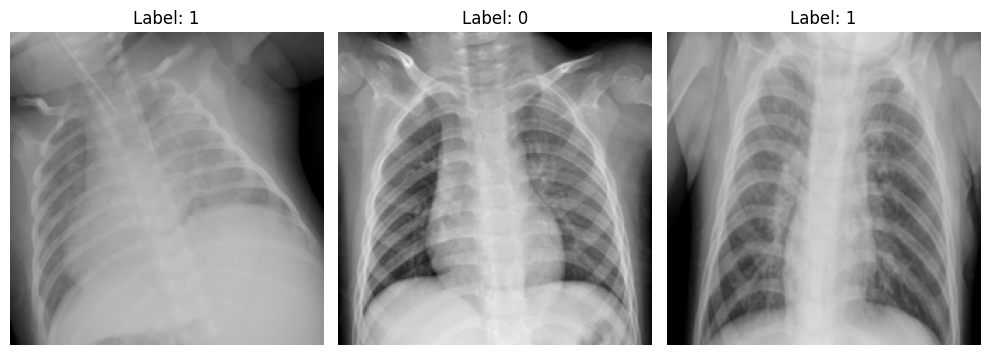

In [4]:

examples_iter = iter(train_loader)
images, labels = next(examples_iter)

plt.figure(figsize=(10,4))
for i in range(3):
    img = images[i]
    print(img.shape)
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Load Pretrained Model

In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=512, out_features=2) # Replace last layer with output features of 2 to match our classes.
model.to(device)

"Model has been set up."


'Model has been set up.'

# Feature Extraction

Training classifier head only.

## Setup

In [6]:
for param in model.parameters():
    param.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, eta_min=1e-5, T_0=10, T_mult=2)
criterion = nn.CrossEntropyLoss()

metrics = {"train_loss": [], "val_acc": []}
best_val_acc = 0

## Train Loop

In [ ]:
epochs = 1

for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_acc = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(X)
            acc = y_pred.argmax(dim=1) == y
            val_acc += acc.sum().item()

    train_loss = train_loss / len(train_loader)
    val_acc = val_acc / len(test_dataset)

    metrics["train_loss"].append(train_loss)
    metrics["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": model.state_dict(),
            "metrics": metrics,
        }, "best_model_feature_extraction.pth")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save({
    "model": model.state_dict(),
    "metrics": metrics,
}, "final_model_feature_extraction.pth")

Epoch 1/1, Train Loss: 0.3086, Val Acc: 0.7131


# Additional Fine-Tuning

Train a few more epochs with added fine-tuning (unfreezing the backbone)

In [8]:
for param in model.parameters():
    param.requires_grad = True

fc_params = list(model.fc.parameters())
fc_param_ids = set(id(p) for p in fc_params)

other_params = [p for p in model.parameters() if id(p) not in fc_param_ids]

optimizer = optim.Adam([
    {"params": other_params, "lr": 0.00001},
    {"params": fc_params, "lr": 0.001}
])

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, eta_min=1e-5, T_0=10, T_mult=2)

## Training Loop

In [ ]:
epochs = 1

for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_acc = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(X)
            acc = y_pred.argmax(dim=1) == y
            val_acc += acc.sum().item()

    train_loss = train_loss / len(train_loader)
    val_acc = val_acc / len(test_dataset)

    metrics["train_loss"].append(train_loss)
    metrics["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": model.state_dict(),
            "metrics": metrics,
        }, "best_model_additional_finetuning.pth")
            
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save({
    "model": model.state_dict(),
    "metrics": metrics,
}, "final_model_additional_finetuning.pth")

KeyboardInterrupt: 